# Boundary Equilibrimum infoGANs for Fault Detection example

## 초기 설정들

In [1]:
import tensorflow as tf
import numpy as np
import os
import sys
import time
import time 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 

os.environ["CUDA_VISIBLE_DEVICES"]="0"


import pickle
import gzip

file_dir = 'anoGANs_MNIST_data/'

with gzip.open(file_dir + 'test_normal_data.pickle.gzip','rb') as f :
    test_normal_data = pickle.load(f)
    print('test_normal_data : ' ,test_normal_data.shape)

with gzip.open(file_dir + 'test_anomalous_data.pickle.gzip','rb') as f :
    test_anomalous_data = pickle.load(f)
    print('test_anomalous_data : ',test_anomalous_data.shape)
    
with gzip.open(file_dir + 'train_normal_data.pickle.gzip','rb') as f :
    train_normal_data = pickle.load(f)
    print('train_normal_data : ', train_normal_data.shape)
    
with gzip.open(file_dir + 'train_anomalous_data.pickle.gzip','rb') as f :
    train_anomalous_data = pickle.load(f)
    print('train_anomalous_data : ',train_anomalous_data.shape )

def idx_shuffle(x) : 
    l = x.shape[0]
    idx = np.arange(l)
    np.random.shuffle(idx)
    shuffled_x = np.empty(x.shape)

    for i in range(l):
        shuffled_x[idx[i]] = x[i]
    
    return shuffled_x

def mnist_4by4_save(samples,path):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)    
    gs.update(wspace=0.05, hspace=0.05) #이미지 사이간격 조절
  
    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')    
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
   
        plt.imshow(sample.reshape(64, 64), cmap='Greys_r',clim=(0.0,1.0))
    plt.colorbar()
    plt.savefig(path, bbox_inches='tight')
    plt.close(fig)
   
    return None

def gan_loss_graph_save(G_loss,D_loss,path):
    x1 = range(len(G_loss))
    x2 = range(len(D_loss))
      
    y1 = G_loss
    y2 = D_loss
  
      
    plt.plot(x1,y1,label='G_loss') 
    plt.plot(x2,y2,label='D_loss') 
  
    plt.xlabel('weight per update')
    plt.ylabel('loss')             
    plt.legend(loc=4)              
    plt.grid(True)
    plt.tight_layout()
  
    plt.savefig(path)              

    return None

file_name = 'ex_BE_infoGANs_for_FD_v3'

if not os.path.isdir(file_name) :
    os.mkdir(file_name)


test_normal_data :  (5139, 64, 64, 1)
test_anomalous_data :  (4861, 64, 64, 1)
train_normal_data :  (28038, 64, 64, 1)
train_anomalous_data :  (26962, 64, 64, 1)


## 네트워크 정의

D부분을 encoder와 discriminator로 나눈 이유는 encoder를 나중에 feature map으로 쓰기 위해서 편의상 나누어서 정의함



In [2]:


train_epoch = 50
batch_size = 100
z_size = 100
lam = 0.001
gamma = 0.7
k_curr = 0.0
c_size = 10


def G(x,c,isTrain = True, reuse = False, name = 'G') : #input = (minibatch * w * h * ch)
    
    # out size = (in size + 2*padding - kenel)/strides + 1    
    w_init = tf.truncated_normal_initializer(mean= 0.0, stddev=0.02)
    b_init = tf.constant_initializer(0.0)

    with tf.variable_scope('G',reuse=reuse)  :
        
        #x = (-1, 1, 1, 100)
        x_concat = tf.concat([x,c],3)
        conv1 = tf.layers.conv2d_transpose(x_concat,512,[4,4], strides=(1,1),padding = 'valid',
                kernel_initializer=w_init, bias_initializer=b_init) 
        r1 = tf.nn.elu(tf.layers.batch_normalization(conv1,training=isTrain))#4*4*512
        
        conv2 = tf.layers.conv2d_transpose(r1,256,[5,5], strides=(2,2),padding = 'same',
                kernel_initializer=w_init, bias_initializer=b_init)
        r2 = tf.nn.elu(tf.layers.batch_normalization(conv2,training=isTrain))#8*8*256
                
        conv3 = tf.layers.conv2d_transpose(r2,128,[5,5], strides=(2,2),padding = 'same',
                kernel_initializer=w_init, bias_initializer=b_init)
        r3 = tf.nn.elu(tf.layers.batch_normalization(conv3,training=isTrain))#16*16*128

        conv4 = tf.layers.conv2d_transpose(r3,64,[5,5], strides=(2,2),padding = 'same',
                kernel_initializer=w_init, bias_initializer=b_init)
        r4 = tf.nn.elu(tf.layers.batch_normalization(conv4,training=isTrain))#32*32*64

        conv5 = tf.layers.conv2d_transpose(r4,1,[5,5], strides=(2,2),padding = 'same',
                kernel_initializer=w_init, bias_initializer=b_init) #64*64*1
        
    r5= tf.nn.tanh(conv5,name=name)#64*64*1
  
    return r5

def E(x,isTrain = True, reuse = False, name = 'E') : #input = (minibatch * w * h * ch)
    
    # out size = (in size + 2*padding - kenel)/strides + 1    
    w_init = tf.truncated_normal_initializer(mean= 0.0, stddev=0.02)
    b_init = tf.constant_initializer(0.0)

    with tf.variable_scope('E',reuse=reuse)  :
        
        #x = (-1, 64, 64, 1)

        conv1 = tf.layers.conv2d(x,128,[5,5], strides=(2,2),padding = 'same',
                kernel_initializer=w_init, bias_initializer=b_init) 
        r1 = tf.nn.elu(conv1)#32*32*64
        
        conv2 = tf.layers.conv2d(r1,256,[5,5], strides=(2,2),padding = 'same',
                kernel_initializer=w_init, bias_initializer=b_init)
        r2 = tf.nn.elu(tf.layers.batch_normalization(conv2,training=isTrain))#16*16*128
                
        conv3 = tf.layers.conv2d(r2,512,[5,5], strides=(2,2),padding = 'same',
                kernel_initializer=w_init, bias_initializer=b_init)
        r3 = tf.nn.elu(tf.layers.batch_normalization(conv3,training=isTrain))#8*8*256

        conv4 = tf.layers.conv2d(r3,1024,[5,5], strides=(2,2),padding = 'same',
                kernel_initializer=w_init, bias_initializer=b_init)
        r4 = tf.nn.elu(tf.layers.batch_normalization(conv4,training=isTrain))#4*4*512

        conv5 = tf.layers.conv2d(r4,100,[4,4], strides=(1,1),padding = 'valid',
                kernel_initializer=w_init, bias_initializer=b_init) #1*1*100
        
        #
        
        fc0  = tf.reshape(conv4, (-1, 4*4*1024))
        
        w1 = tf.get_variable('w1',[4*4*1024, c_size],initializer=w_init)
        b1 = tf.get_variable('b1',[c_size],initializer=b_init)
        
                                          
        fc1 = tf.nn.softmax(tf.matmul(fc0,w1) + b1, name = name)
        
        
    r5 = tf.nn.tanh(tf.layers.batch_normalization(conv5,training=isTrain), name = name)#4*4*512
  
  
    return r5, tf.reshape(fc1,(-1,1,1,c_size))




def D_enc(x,isTrain=True,reuse = False, name = 'D_enc') :
    
    w_init = tf.truncated_normal_initializer(mean= 0.0, stddev=0.02)
    b_init = tf.constant_initializer(0.0)
    with tf.variable_scope('D_enc', reuse=reuse) :
        
        #x = (-1,64,64,1)
        # out size = (in size + 2*padding - kenel)/strides + 1   

        conv1 = tf.layers.conv2d(x,64,[5,5], strides=(2,2),padding = 'same',
                                kernel_initializer=w_init, bias_initializer=b_init) 
        r1 = tf.nn.elu(conv1)#32*32*64

   
        conv2 = tf.layers.conv2d(r1,128,[5,5], strides=(2,2),padding = 'same',
                                kernel_initializer=w_init, bias_initializer=b_init)
        r2 = tf.nn.elu(tf.layers.batch_normalization(conv2,training=isTrain))#16*16*128

  
        conv3 = tf.layers.conv2d(r2,256,[5,5], strides=(2,2),padding = 'same',
                                kernel_initializer=w_init, bias_initializer=b_init)
        r3 = tf.nn.elu(tf.layers.batch_normalization(conv3,training=isTrain))#8*8*256
        
        conv4 = tf.layers.conv2d(r3,512,[5,5], strides=(2,2),padding = 'same',
                                kernel_initializer=w_init, bias_initializer=b_init)    
        r4 = tf.nn.elu(tf.layers.batch_normalization(conv4,training=isTrain), name = name)#4*4*512
        
        conv5 = tf.layers.conv2d(r4,100,[4,4], strides=(1,1),padding = 'valid',
                                kernel_initializer=w_init, bias_initializer=b_init)    
        r5 = tf.layers.batch_normalization(conv5,training=isTrain)
    return tf.add(r5,0,name=name)

def D_dec(x,isTrain=True,reuse = False, name = 'D_dec') :
    
    w_init = tf.truncated_normal_initializer(mean= 0.0, stddev=0.02)
    b_init = tf.constant_initializer(0.0)
    with tf.variable_scope('D_dec', reuse=reuse) :
        
        #x = (-1,64,64,1)
        # out size = (in size + 2*padding - kenel)/strides + 1   
        # 256*16*16
        # 128*32*32
        # 1*64*64
        conv6 = tf.layers.conv2d_transpose(x,512,[4,4], strides=(1,1),padding = 'valid',
                                kernel_initializer=w_init, bias_initializer=b_init)
        r6 = tf.nn.elu(tf.layers.batch_normalization(conv6,training=isTrain))#4*4*256
        
        conv7 = tf.layers.conv2d_transpose(r6,256,[5,5], strides=(2,2),padding = 'same',
                                kernel_initializer=w_init, bias_initializer=b_init)
        r7 = tf.nn.elu(tf.layers.batch_normalization(conv7,training=isTrain))#8*8*256


        conv8 = tf.layers.conv2d_transpose(r7,128,[5,5], strides=(2,2),padding = 'same',
                                kernel_initializer=w_init, bias_initializer=b_init)
        r8 = tf.nn.elu(tf.layers.batch_normalization(conv8,training=isTrain))#16*16*128
             
        conv9 = tf.layers.conv2d_transpose(r8,64,[5,5], strides=(2,2),padding = 'same',
                                kernel_initializer=w_init, bias_initializer=b_init)
        r9 = tf.nn.elu(tf.layers.batch_normalization(conv9,training=isTrain))#32*32*64
          
        conv10 = tf.layers.conv2d_transpose(r9,1,[5,5], strides=(2,2),padding = 'same',
                kernel_initializer=w_init, bias_initializer=b_init) #64*64*1
        
    r10= tf.nn.tanh(conv10,name=name)#64*64*1
    
    return r10
def Q_cat(x,reuse = False, name = 'Q_cat') :
    
    w_init = tf.truncated_normal_initializer(mean= 0.0, stddev=0.02)
    b_init = tf.constant_initializer(0.0)
    with tf.variable_scope('Q_cat', reuse=reuse) :
        
        #x = (-1,64,64,1)
        # out size = (in size + 2*padding - kenel)/strides + 1   
        fc0  = tf.reshape(x, (-1, 100))
        
        w1 = tf.get_variable('w1',[100, c_size],initializer=w_init)
        b1 = tf.get_variable('b1',[c_size],initializer=b_init)
        
                                          
    fc1 = tf.nn.softmax(tf.matmul(fc0,w1) + b1, name = name)
    
    return tf.reshape(fc1, (-1,1,1,c_size))


## 네트워크 연결

In [3]:




z = tf.placeholder(tf.float32,shape=(None,1,1,z_size),name = 'z')    #x_z = G(z)
c = tf.placeholder(tf.float32,shape=(None,1,1,c_size),name = 'c')    #x_z = G(z,c)

u = tf.placeholder(tf.float32, shape = (None, 64,64,1),name='u')      #u = x
k = tf.placeholder(tf.float32, name = 'k')


isTrain = tf.placeholder(dtype=tf.bool,name='isTrain')  # BN 설정 parameter


G_sample = G(z,c,name='G_sample') # G(z)
E_z, E_c = E(u,isTrain,name = 'E_z') 

re_image = G(E_z,E_c, isTrain, reuse=True, name ='re_image')
re_z, re_c = E(G_sample, isTrain, reuse=True, name ='re_z')



re_z_loss = tf.reduce_mean(tf.sqrt(tf.reduce_sum((re_z - z)**2, axis=[1,2,3])) , name = 're_z_loss') 
re_c_loss = tf.reduce_mean(tf.reduce_sum(-c*tf.log(re_c + 1e-8), axis = [1,2,3]),name = 're_c_loss')
re_image_loss = tf.reduce_mean(tf.sqrt(tf.reduce_sum((re_image - u)**2, axis=[1,2,3])) , name = 're_image_loss') 


E_loss = tf.add(re_z_loss, re_c_loss, name = 'E_loss')                       


D_real = D_dec(D_enc(u, isTrain,reuse=False), isTrain, reuse=False, name = 'D_real')                       # D(x)
D_fake = D_dec(D_enc(G_sample, isTrain,reuse=True), isTrain, reuse=True, name = 'D_fake')         # D(G(z))
Q_fake = Q_cat(D_enc(G_sample, isTrain,reuse=True), reuse=False, name='Q_fake')

#input = (minibatch * w * h * ch)
D_real_loss = tf.reduce_mean(tf.sqrt(tf.reduce_sum((D_real-u)**2, axis=[1,2,3])) , name = 'D_real_loss')             

D_fake_loss = tf.reduce_mean(tf.sqrt(tf.reduce_sum((D_fake - G_sample)**2, axis=[1,2,3])),  name = 'D_fake_loss' )

D_loss =  tf.add(D_real_loss, -k*D_fake_loss, name='D_loss')                                        

G_loss =  tf.reduce_mean(tf.sqrt(tf.reduce_sum((D_fake - G_sample)**2, axis=[1,2,3])), name='G_loss')                             # E[-log(D(G(z)))]
Q_loss = tf.reduce_mean(tf.reduce_sum(-c*tf.log(Q_fake + 1e-8), axis = [1,2,3]),name = 'Q_loss')

                                                                                                                                
T_vars = tf.trainable_variables()
D_vars = [var for var in T_vars if var.name.startswith('D_dec') or var.name.startswith('D_enc')]
G_vars = [var for var in T_vars if var.name.startswith('G')]
E_vars = [var for var in T_vars if var.name.startswith('E')]
Q_vars = [var for var in T_vars if var.name.startswith('Q')]

    # When using the batchnormalization layers,
    # it is necessary to manually add the update operations
    # because the moving averages are not included in the graph
with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)) :        
    D_optim = tf.train.AdamOptimizer(2e-5,beta1=0.5).minimize(D_loss, var_list=D_vars, name='D_optim') 
    G_optim = tf.train.AdamOptimizer(2e-4,beta1=0.5).minimize(G_loss + Q_loss, var_list=G_vars+Q_vars, name='G_optim')
    E_optim = tf.train.AdamOptimizer(2e-4,beta1=0.1).minimize(E_loss, var_list=E_vars, name='E_optim')
    E_AE_optim = tf.train.AdamOptimizer(2e-4,beta1=0.1).minimize(re_image_loss, var_list=E_vars, name='E_AE_optim')



## 학습

D_e : 30.714, D_real_e : 40.475, D_fake_e : 26.956, G_e : 27.525, Q_e : 2.127, new_measure : 47.387, k_curr : 0.226277
D_e : 23.627, D_real_e : 26.613, D_fake_e : 18.862, G_e : 19.158, Q_e : 2.108, new_measure : 27.943, k_curr : 0.078170
D_e : 19.634, D_real_e : 20.005, D_fake_e : 14.188, G_e : 14.267, Q_e : 2.039, new_measure : 21.672, k_curr : 0.004366
D_e : 15.989, D_real_e : 15.927, D_fake_e : 11.070, G_e : 11.078, Q_e : 1.938, new_measure : 17.220, k_curr : 0.024312
D_e : 12.979, D_real_e : 13.080, D_fake_e : 9.260, G_e : 9.276, Q_e : 1.778, new_measure : 14.028, k_curr : -0.009285
D_e : 11.604, D_real_e : 11.417, D_fake_e : 8.011, G_e : 8.016, Q_e : 1.598, new_measure : 12.275, k_curr : -0.015864
D_e : 10.254, D_real_e : 10.144, D_fake_e : 7.030, G_e : 7.058, Q_e : 1.429, new_measure : 10.866, k_curr : -0.003694
D_e : 9.186, D_real_e : 9.271, D_fake_e : 6.338, G_e : 6.392, Q_e : 1.281, new_measure : 9.873, k_curr : 0.023752
D_e : 8.687, D_real_e : 8.710, D_fake_e : 6.206, G_e : 6

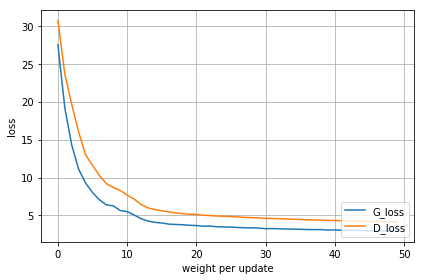

In [4]:
tf.set_random_seed(int(time.time()))
with tf.Session(config=tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))) as sess :
    sess.run(tf.global_variables_initializer())

    np.random.seed(int(time.time()))
    tf.set_random_seed(int(time.time()))
    
    one_hot = np.eye(c_size)
    temp2 = np.array([1,1,1,1,2,2,2,2,3,3,3,3,4,4,4,4])
    test_c = one_hot[temp2].reshape([-1,1,1,c_size])
    test_z = np.random.uniform(-1,1,size=(16,1,1,z_size))
    mnist_4by4_save(np.reshape(test_normal_data[0:16],(-1,64,64,1)),file_name + '/D_origin.png')    
    mnist_4by4_save(np.reshape(test_anomalous_data[0:16],(-1,64,64,1)),file_name + '/anomalous.png')    
    log_txt = open(file_name +'/log.txt','w')

    hist_G = []
    hist_D = []
    G_error = []
    D_error = []
    Q_error=[]
    E_error = []
    D_fake_error = []
    D_real_error = []
    new_measure = []
    new_k = []
    
    start = time.time()
    for epoch in range(train_epoch) :
        
        train_normal_data = idx_shuffle(train_normal_data) 
        
        for iteration in range(train_normal_data.shape[0] // batch_size) : 
        
            
            train_images = train_normal_data[iteration*batch_size : (iteration+1)*batch_size]      
            u_ = np.reshape(train_images,(-1,64,64,1)) 
            z_ = np.random.uniform(-1,1,size=(batch_size,1,1,z_size))
            temp1 = np.random.randint(0,10,(batch_size))                                                                                                                                     
            c_ = one_hot[temp1].reshape([-1,1,1,c_size])
        
            _ , D_e,D_real_e,D_fake_e = sess.run([D_optim, D_loss,D_real_loss,D_fake_loss], {u : u_, z : z_, c : c_, k : k_curr,isTrain : True})
            D_error.append(D_e)
            D_real_error.append(np.maximum(0.0, D_real_e))
            D_fake_error.append(np.maximum(0.0,D_fake_e))

            #    train_images,train_labels = mnist.train.next_batch(100)    
            #    u_ = np.reshape(train_images,(-1,64,64,1)) 
            #    z_ = np.random.normal(0,1,size=(100,1,1,100))
   
            _ , G_e,Q_e = sess.run([G_optim, G_loss,Q_loss], {u : u_, z : z_, c : c_, k : k_curr, isTrain : True}) 
            G_error.append(G_e)
            Q_error.append(Q_e)

            
            k_curr = k_curr + lam * (gamma*D_real_e - G_e)
            

            
            measure = D_real_e + np.abs(gamma*D_real_e - G_e)
            
            new_measure.append(measure)
            new_k.append(k_curr)
        hist_D.append(np.mean(D_error)) 
        hist_G.append(np.mean(G_error))

        print('D_e : %.3f, D_real_e : %.3f, D_fake_e : %.3f, G_e : %.3f, Q_e : %.3f, new_measure : %.3f, k_curr : %3f'
              %(np.mean(D_error), np.mean(D_real_error),np.mean(D_fake_error), np.mean(G_error),
                np.mean(Q_error),np.mean(new_measure),k_curr))
        log_txt.write('D_e : %.6f, D_real_e : %.6f, D_fake_e : %.6f, G_e : %.6f\n'%(np.mean(D_error),
            np.mean(D_real_error), np.mean(D_fake_error), np.mean(G_error)))
      
        r = sess.run([G_sample],feed_dict={z : test_z, c : test_c, isTrain : False})       
        mnist_4by4_save(np.reshape(r,(-1,64,64,1)),file_name + '/result_{}.png'.format(str(epoch).zfill(3)))

        r = sess.run([D_real],feed_dict={u : test_normal_data[0:16], isTrain : False})        
        mnist_4by4_save(np.reshape(r,(-1,64,64,1)),file_name + '/D_{}.png'.format(str(epoch).zfill(3)))
        
        
        
        np.random.seed(int(time.time()))


        G_error = []
        D_error = []       
        D_fake_error = []     
        D_real_error = []
        new_measure = []
    
    
    log_txt.close()
    gan_loss_graph_save(G_loss = hist_G,D_loss=hist_D,path = file_name + '/loss_graph.png')   
    saver = tf.train.Saver()
    saver.save(sess,file_name + '/para.cktp')

    end = time.time()-start

    print("total time : ",end)

## network load

In [5]:
if not os.path.isdir(file_name) :
    os.mkdir(file_name)

    
sess = tf.InteractiveSession()
    
new_saver = tf.train.import_meta_graph(file_name + '/para.cktp.meta')
new_saver.restore(sess, tf.train.latest_checkpoint(file_name + '/'))


z = sess.graph.get_tensor_by_name("z:0")
u = sess.graph.get_tensor_by_name("u:0")

isTrain = sess.graph.get_tensor_by_name("isTrain:0")

G_sample = sess.graph.get_tensor_by_name("G_sample:0")

D_real = sess.graph.get_tensor_by_name('D_real:0')                       # D(x)
D_fake = sess.graph.get_tensor_by_name('D_fake:0')         # D(G(z))


D_real_loss = sess.graph.get_tensor_by_name('D_real_loss:0')
D_fake_loss = sess.graph.get_tensor_by_name('D_fake_loss:0')

D_loss = sess.graph.get_tensor_by_name("D_loss:0")
G_loss = sess.graph.get_tensor_by_name("G_loss:0")


D_optim = sess.graph.get_operation_by_name("D_optim")
G_optim = sess.graph.get_operation_by_name("G_optim")





INFO:tensorflow:Restoring parameters from ex_BE_infoGANs_for_FD_v3/para.cktp


In [6]:
re_z

<tf.Tensor 're_z:0' shape=(?, 1, 1, 100) dtype=float32>

In [7]:
new_k

[0.019468553543090822,
 0.04026400299072265,
 0.061689060211181632,
 0.08362643013000487,
 0.10600821037292479,
 0.12886114692687986,
 0.1520805812835693,
 0.17578715171813961,
 0.19987262649536128,
 0.22393819694519038,
 0.24826513442993159,
 0.27283307113647454,
 0.29758060379028312,
 0.32229133148193351,
 0.34720723228454581,
 0.37189029312133781,
 0.39639181613922109,
 0.42071768245697011,
 0.44499780426025382,
 0.46901111660003653,
 0.49261714572906484,
 0.51594084434509269,
 0.53905758399963366,
 0.56182398662567123,
 0.58430557060241683,
 0.60616753330230699,
 0.62753137092590316,
 0.64807164688110341,
 0.66829618263244617,
 0.68752054672241203,
 0.70566615295410151,
 0.72296960525512688,
 0.73953231849670398,
 0.75411979751586899,
 0.76756458091735824,
 0.78048499565124496,
 0.79091335601806623,
 0.79979460220336895,
 0.80840978507995587,
 0.81618667297363268,
 0.82279196090698226,
 0.82740845069885238,
 0.83094952278137191,
 0.8339269027709959,
 0.83745334663391091,
 0.8406795

In [8]:
D_fake_error

[]

In [9]:
D_real_error

[]

In [10]:
int(time.time())

1543312448